# Overview

**Requirements**
- Project must include 2 models
- At least one using deep learning
- At least one time series prediction


**Notes**
- Build a LSTM to predict 'overall_score' based on other features (satisfies deep learning & time series req.)
- Build a traditional ML classifier to classify important features as bad, average or good for daily notifications in a smart watch




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
# Feature importance
from sklearn.ensemble import RandomForestRegressor
# TF
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LambdaCallback
import os
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path
path = '/content/drive/MyDrive/530 Final/IoT AAI-530 Final Project/'

# list of all files in the path
files = os.listdir(path)

# create dataframes
dfs = {}
for file in files:
    if file.endswith('.csv'): # only process .csv files
        dfs[file[:-4]] = pd.read_csv(os.path.join(path, file), encoding='ISO-8859-1')

In [ ]:
df = dfs['sleep_score']

In [ ]:
# df = pd.read_csv('/content/drive/My Drive/IoT AAI-530 Final Project/sleep_score.csv')

#Exploratory Data Analysis

In [ ]:
df.head(1)

,timestamp,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2023-11-18T07:59:00Z,83,83,104,63,0.0681


In [ ]:
# Datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values('timestamp', inplace=True)

In [ ]:
# Missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 timestamp                0
overall_score            0
revitalization_score     0
deep_sleep_in_minutes    0
resting_heart_rate       0
restlessness             0
dtype: int64


In [ ]:
df.describe()

,overall_score,revitalization_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
count,291.000000,291.000000,291.000000,291.000000,291.000000
mean,75.189003,75.189003,91.292096,62.171821,0.067268
std,7.614552,7.614552,28.807337,2.831722,0.021966
min,45.000000,45.000000,18.000000,55.000000,0.032702
25%,70.000000,70.000000,69.500000,60.000000,0.052605
50%,76.000000,76.000000,91.000000,62.000000,0.062626
75%,81.500000,81.500000,110.500000,64.000000,0.077261
max,89.000000,89.000000,179.000000,70.000000,0.185596


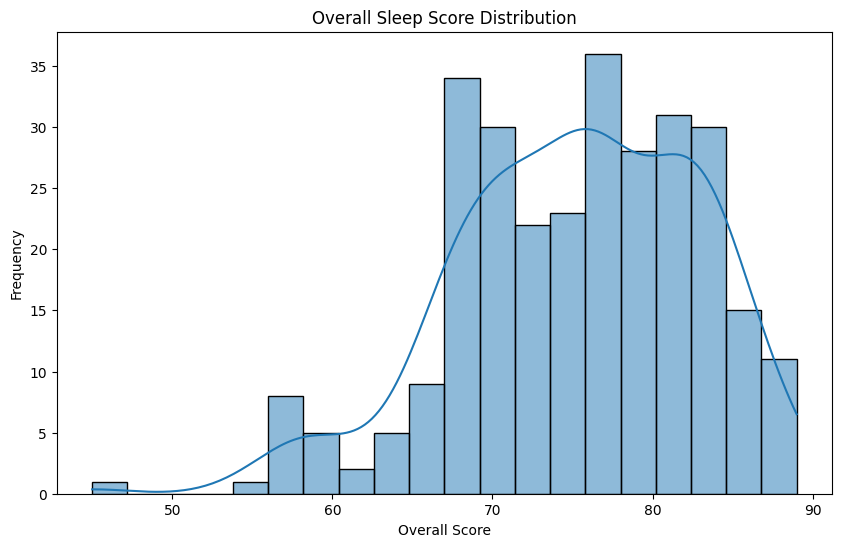

In [ ]:
# Distribution of Overall Sleep Score
plt.figure(figsize=(10, 6))
sns.histplot(df['overall_score'], kde=True, bins=20)
plt.title('Overall Sleep Score Distribution')
plt.xlabel('Overall Score')
plt.ylabel('Frequency')
plt.show()

<ipython-input-14-505e2d532d6e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


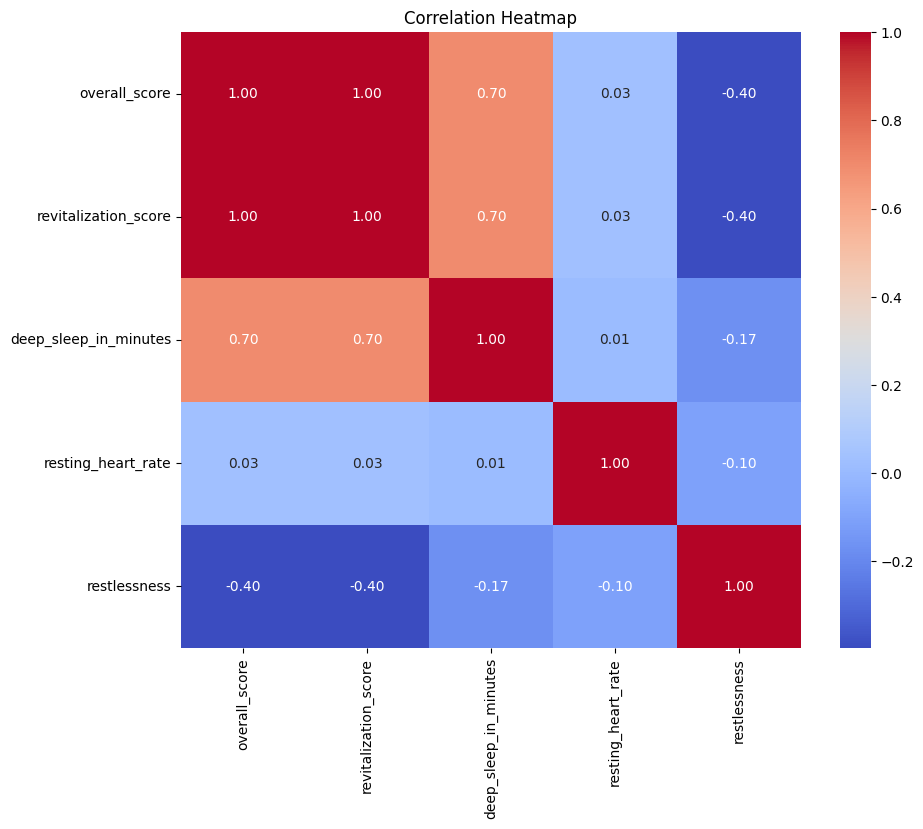

In [ ]:
## Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Notes

- Target variable: 'overall_score'
- 'deep_sleep_in_minutes' has a high correlation of 0.70
- 'restlessness' has a notable negative correlation of -0.40

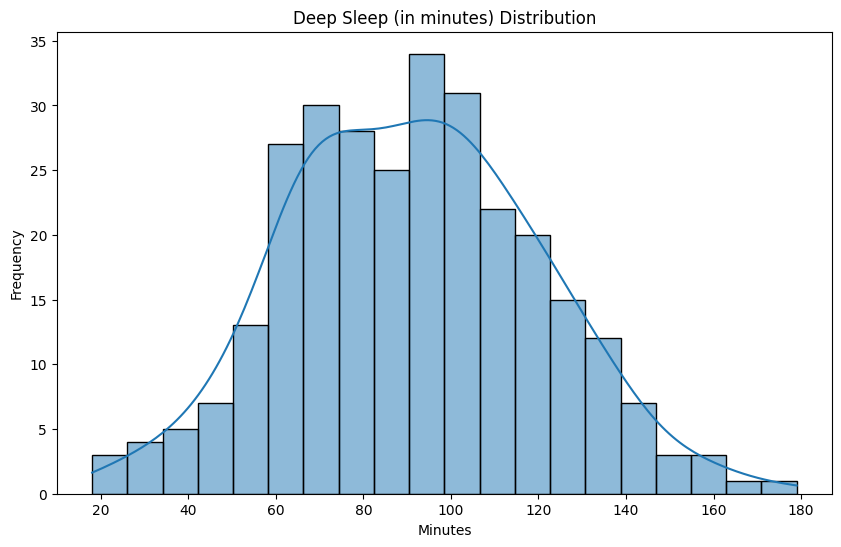

In [ ]:
# Distribution of Deep Sleep
plt.figure(figsize=(10, 6))
sns.histplot(df['deep_sleep_in_minutes'], kde=True, bins=20)
plt.title('Deep Sleep (in minutes) Distribution')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

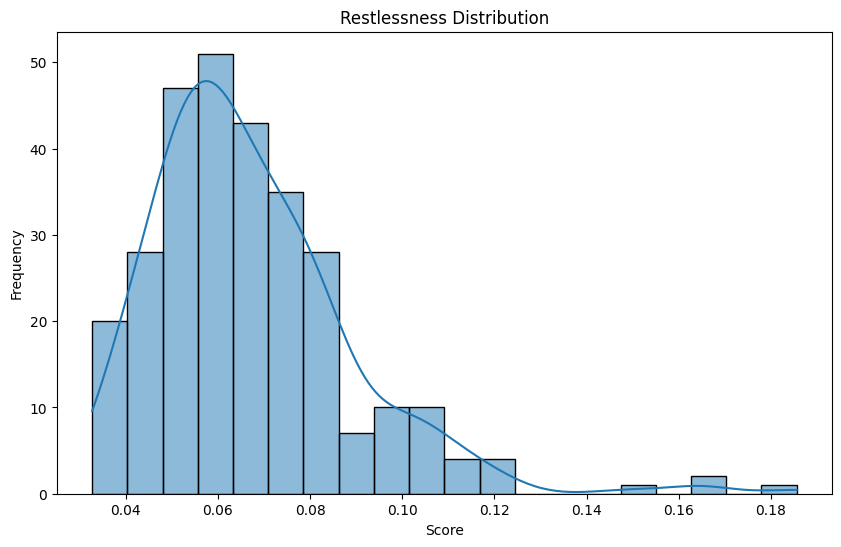

In [ ]:
# Distribution of Restlessness
plt.figure(figsize=(10, 6))
sns.histplot(df['restlessness'], kde=True, bins=20)
plt.title('Restlessness Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

Feature Engineering

- Add lagged features
- Add noise

In [ ]:
# Lag features for 'deep_sleep_in_minutes' and 'overall_score'
for lag in range(1, 8):
    df[f'deep_sleep_in_minutes_lag{lag}'] = df['deep_sleep_in_minutes'].shift(lag)
    df[f'overall_score_lag{lag}'] = df['overall_score'].shift(lag)

# Drop rows with NaN values created by lagging
df.dropna(inplace=True)

In [ ]:
# Add noise to features (excluding 'timestamp' and 'overall score')
noise_strength = 0.01
features_to_noise = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)]
for feature in features_to_noise:
    df[feature] += np.random.normal(0, noise_strength, df.shape[0])

# LSTM

Traditional ML Classifier

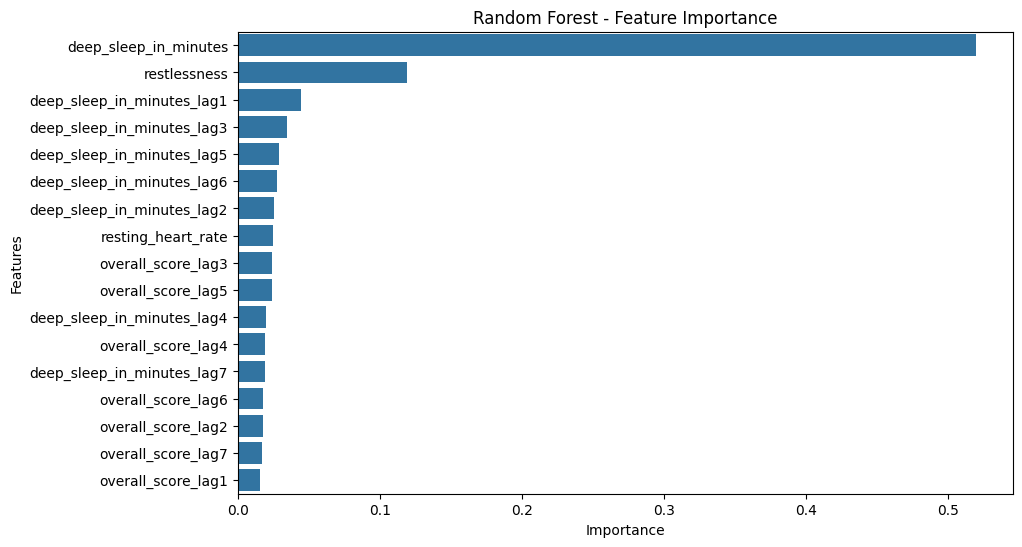

In [ ]:
# Feature importances
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(features, target)

importances = rf.feature_importances_
importances_series = pd.Series(importances, index=features_columns)
sorted_importances = importances_series.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_importances.index)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.show()

In [ ]:
# Bin deep sleep based on z-scores
mean = df['deep_sleep_in_minutes'].mean()
std_dev = df['deep_sleep_in_minutes'].std()
df['z_score'] = (df['deep_sleep_in_minutes'] - mean) / std_dev
df['deep_sleep_category'] = df['z_score'].apply(lambda z: 'Poor' if z < -1 else ('Average' if z < 1 else 'Good'))

# Bin restlessness based on z-scores
mean_restlessness = df['restlessness'].mean()
std_dev_restlessness = df['restlessness'].std()
df['z_score_restlessness'] = (df['restlessness'] - mean_restlessness) / std_dev_restlessness
df['restlessness_category'] = df['z_score_restlessness'].apply(lambda z: 'Low' if z < -1 else ('Average' if z < 1 else 'High'))

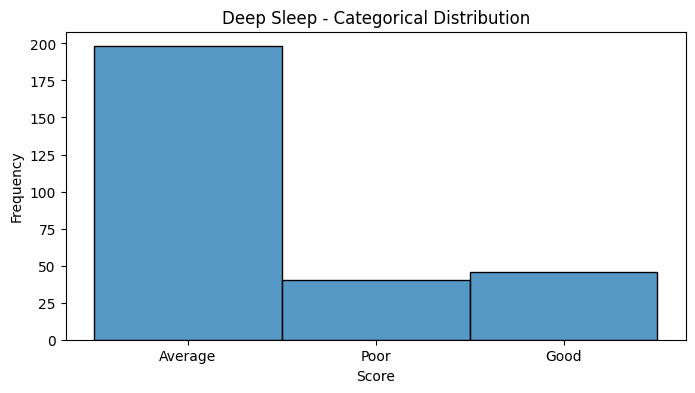

In [ ]:
# Distribution of Deep Sleep - Categorical Variable
plt.figure(figsize=(8, 4))
sns.histplot(df['deep_sleep_category'], kde=False, bins=20)
plt.title('Deep Sleep - Categorical Distribution')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

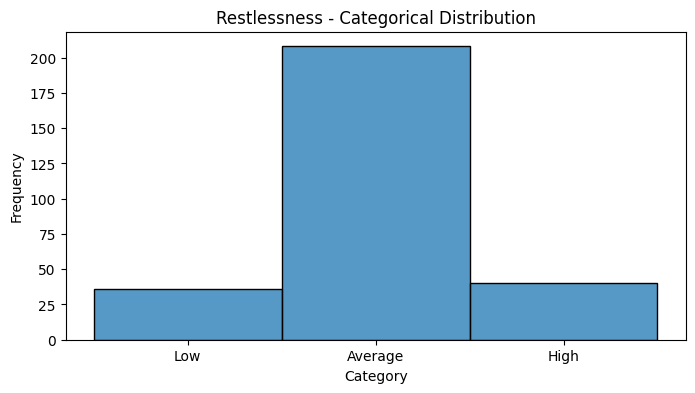

In [ ]:
# Plot the distribution of the restlessness categories
plt.figure(figsize=(8, 4))
sns.histplot(df['restlessness_category'], kde=False, bins=20)
plt.title('Restlessness - Categorical Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

# Deep Learning Neural Network

In [ ]:
# Define the sequence length and predictive horizon
sequence_length = 7
predictive_horizon = 1

# Set target, features, and exclude 'revitalization_score' due to 1.0 correlation with target
features_columns = ['deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness'] + \
                   [f'deep_sleep_in_minutes_lag{lag}' for lag in range(1, 8)] + \
                   [f'overall_score_lag{lag}' for lag in range(1, 8)]

features = df[features_columns]
target = df['overall_score']

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

X = []
y = []

# Generate sequences for feedforward neural network
for i in range(len(scaled_features) - sequence_length - predictive_horizon + 1):
    X.append(scaled_features[i:i + sequence_length].flatten())
    y.append(target.iloc[i + sequence_length + predictive_horizon - 1])

X = np.array(X)
y = np.array(y)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the feedforward neural network model
model = Sequential()

# Dense layers
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150, batch_size=32, validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

# Evaluate the model on the validation set
val_loss, val_mse, val_mae = model.evaluate(X_val, y_val)

print(f"Validation Loss: {val_loss}")
print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation Mean Absolute Error: {val_mae}")


Epoch 1/150
7/7 [==============================] - 2s 33ms/step - loss: 5364.9424 - mse: 5364.9424 - mae: 72.8343 - val_loss: 5733.3740 - val_mse: 5733.3740 - val_mae: 75.4248
Epoch 2/150
7/7 [==============================] - 0s 13ms/step - loss: 4961.6245 - mse: 4961.6245 - mae: 69.9971 - val_loss: 5198.8252 - val_mse: 5198.8252 - val_mae: 71.7954
Epoch 3/150
7/7 [==============================] - 0s 11ms/step - loss: 4429.1953 - mse: 4429.1953 - mae: 66.0701 - val_loss: 4524.0747 - val_mse: 4524.0747 - val_mae: 66.9334
Epoch 4/150
7/7 [==============================] - 0s 8ms/step - loss: 3752.4558 - mse: 3752.4558 - mae: 60.6717 - val_loss: 3698.0886 - val_mse: 3698.0886 - val_mae: 60.4489
Epoch 5/150
7/7 [==============================] - 0s 12ms/step - loss: 3048.5774 - mse: 3048.5774 - mae: 54.5846 - val_loss: 2773.6287 - val_mse: 2773.6287 - val_mae: 52.2391
Epoch 6/150
7/7 [==============================] - 0s 11ms/step - loss: 2172.9485 - mse: 2172.9485 - mae: 45.5336 - val_l

# Visualizing Validation and MAE

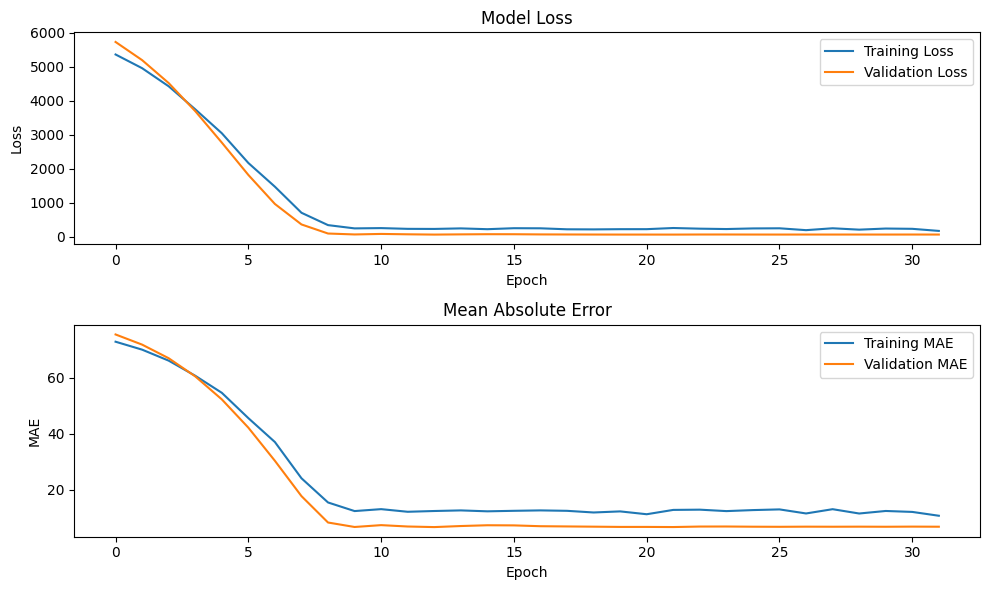

In [ ]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation mean absolute error values
plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Hyperparameter Tuning

In [ ]:
# Define the function to create the model
def create_model(units_layer1=64, dropout_rate=0.5, units_layer2=32, optimizer='adam'):
    model = Sequential()
    model.add(Dense(units_layer1, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units_layer2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse', 'mae'])
    return model

# Define the hyperparameter grid
param_grid = {
    'units_layer1': [32, 64, 128],
    'dropout_rate': [0.3, 0.5, 0.7],
    'units_layer2': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop']
}

# Perform GridSearchCV
best_model = None
best_val_mse = float('inf')

for units_layer1 in param_grid['units_layer1']:
    for dropout_rate in param_grid['dropout_rate']:
        for units_layer2 in param_grid['units_layer2']:
            for optimizer in param_grid['optimizer']:
                # Create the model
                model = create_model(units_layer1, dropout_rate, units_layer2, optimizer)

                # Train the model
                model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

                # Evaluate on validation set
                y_pred = model.predict(X_val)
                val_mse = mean_squared_error(y_val, y_pred)

                # Check if it's the best model
                if val_mse < best_val_mse:
                    best_val_mse = val_mse
                    best_model = model

# Print the best hyperparameters
print("Best Hyperparameters: ", best_model.get_config())

# Evaluate the best model on the validation set
y_pred = best_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_pred)
val_mae = mean_absolute_error(y_val, y_pred)

print(f"Validation Mean Squared Error: {val_mse}")
print(f"Validation Mean Absolute Error: {val_mae}")

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 7ms/step


2/2 [==============================] - 0s 5ms/step
Best Hyperparameters:  {'name': 'sequential_4', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 119), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'dense_10_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_10', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': (None, 119), 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': (None, 119)}}, {'module': 'k

# TODO:

Idea: try to predict how you're going to sleep the next day based on prior data.

Smart Watch Sleep Tracker - you're predicted to sleep poorly.
Time Series Predictor

Level of Deep Sleep was low (last night)
Be on the look outout

## BRANDON

* [ ] Refining the model and the CV.

## ALEC

* [ ] Do RF technique
* [ ] First part of documentation
* [ ] Classification work

## DIAGRAMS

1. [ ] DIAGRAM 1: ML1. LOSS GRAPHS
2. [ ] DIAGRAM 2: ML2. MAE
3. [ ] DIAGRAM 3: SUMMARY GRAPH - whatever major feature
4. [ ] DIAGRAM 4: STATUS GRAPH - current status of IOT device (perhaps next day)

MESSAGES
- STATUS:

[ ] Create system diagram









Similar to Assignment 5, your submitted Tableau Public Dashboard must include:
- At least one status visualization - This visualization should tell the dashboard user something about the “current” status of their IoT device (e.g. number of devices online, current glucose level, etc.)

- At least one summary visualization - This visualization should tell the dashboard user
something about the historical data from their IoT device (e.g. average device downtime
over the last week, number of hypo/hyperglycemic readings over the last week)
- At least one visualization for each of your two machine learning insights -
This visualization should communicate the insights created by your machine
learning methods.
